Agent 1: Retrieving and preprocessing data...
Data successfully loaded from credit_risk_dataset.csv
Data preprocessing complete.

Agent 7: Providing business insights...
Total number of records in the dataset: 31686
Number of rejected loans: 6826
Number of approved loans: 24860
Percentage of rejected loans: 21.54%
Percentage of approved loans: 78.46%

Common characteristics of rejected loans (loan_status=1):
loan_grade loan_intent person_home_ownership
         D     MEDICAL                  RENT

Common characteristics of approved loans (loan_status=0):
loan_grade loan_intent person_home_ownership
         A   EDUCATION              MORTGAGE

Agent 2: Generating data visualizations...


C:\Users\laiyo\AppData\Local\Temp\ipykernel_13376\2349770647.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  self.df['loan_int_rate'].fillna(self.df['loan_int_rate'].median(), inplace=True)
C:\Users\laiyo\AppData\Local\Temp\ipykernel_13376\2349770647.py:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='loan_status', data=self.df, ax=axes[0, 1], palette='viridis')


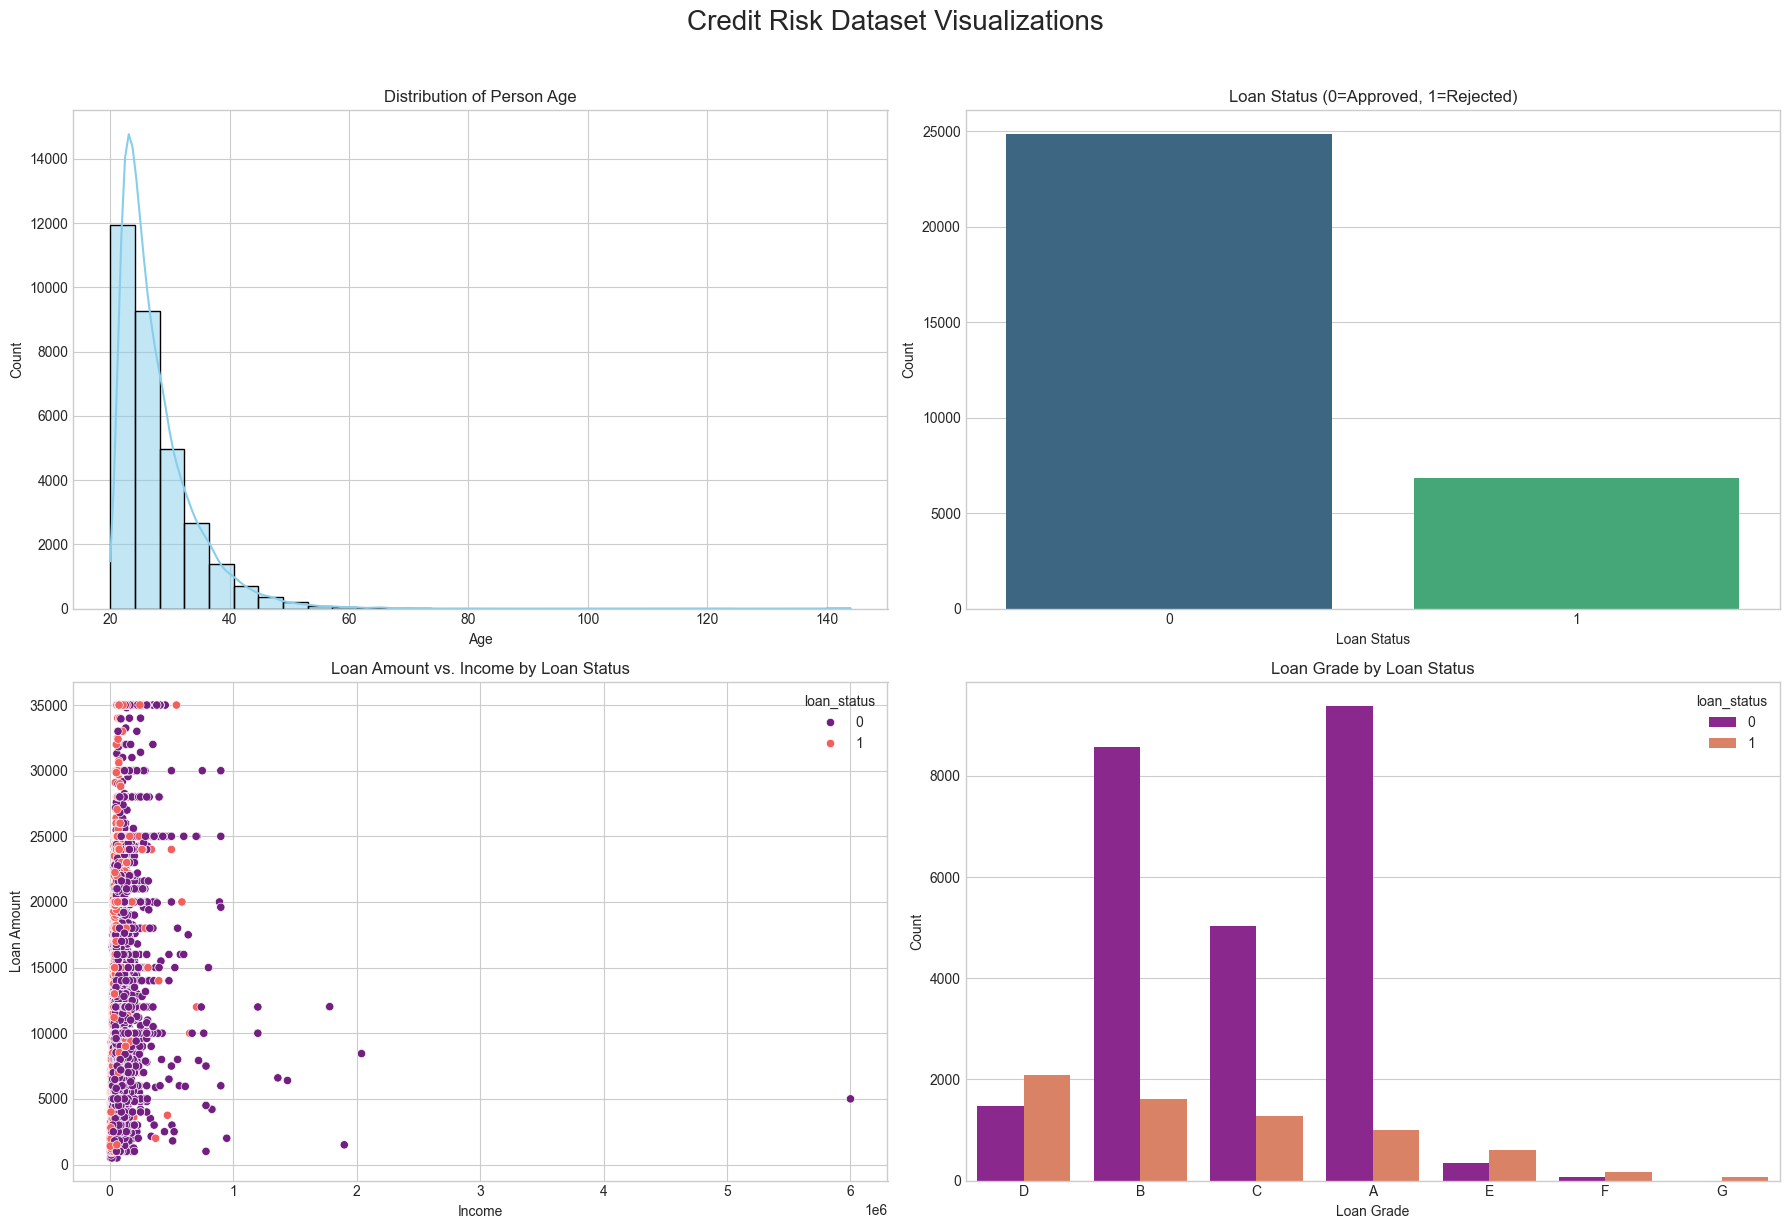

Visualizations displayed successfully.

Agent 3: Training and modeling...
Data split into training and testing sets.
Model training complete.
K-fold cross-validation results (5 folds): [0.92978304 0.93451677 0.93885602 0.93726573 0.93529296]
Mean accuracy from cross-validation: 0.94

Agent 4: Evaluating model performance...

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.92      0.99      0.96      4973
           1       0.97      0.70      0.81      1365

    accuracy                           0.93      6338
   macro avg       0.95      0.85      0.89      6338
weighted avg       0.93      0.93      0.93      6338



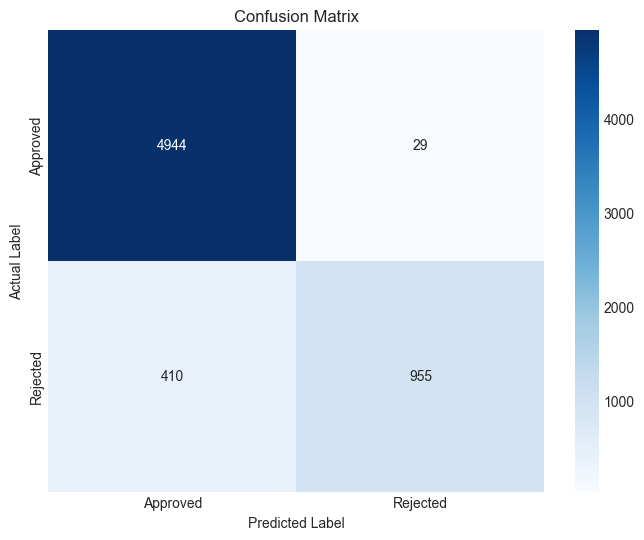

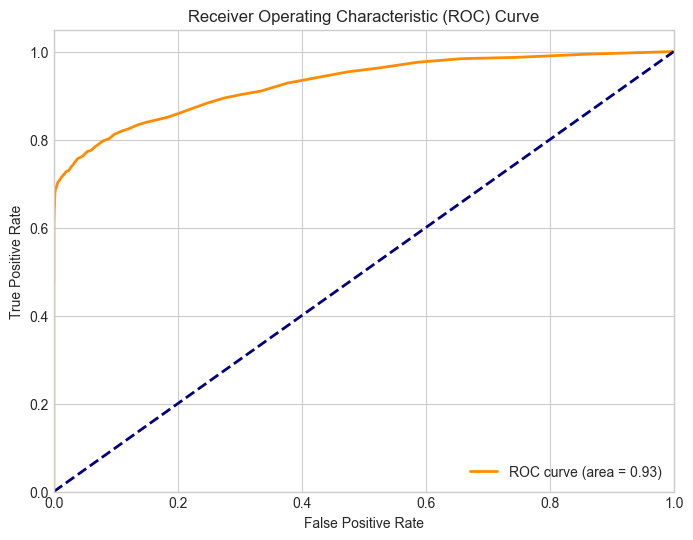


Agent 5: Making prediction on new data...
Prediction for the new applicant: Approved
Approval Probability: 0.97, Rejection Probability: 0.03


NameError: name 'ExplanationAgent' is not defined

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

try:
    import shap
except ImportError:
    print("SHAP library not found. Please install it with 'pip install shap'")
    shap = None


class DataAgent:
    def __init__(self, filename='credit_risk_dataset.csv'):
        self.filename = filename
        self.df = None

    def retrieve_and_preprocess(self):
        print("Agent 1: Retrieving and preprocessing data...")
        try:
            self.df = pd.read_csv(self.filename)
            print(f"Data successfully loaded from {self.filename}")
        except FileNotFoundError:
            print(f"Error: The file '{self.filename}' was not found.")
            return None, None, None, None, None

        # Fill missing loan interest rate with median
        self.df['loan_int_rate'].fillna(self.df['loan_int_rate'].median(), inplace=True)
        # Drop rows where person_emp_length is missing
        self.df.dropna(subset=['person_emp_length'], inplace=True)

        categorical_features = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
        numerical_features = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
                              'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']

        preprocessor = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), numerical_features),
                ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
            ])

        X = self.df.drop('loan_status', axis=1)
        y = self.df['loan_status']
        print("Data preprocessing complete.")
        return X, y, preprocessor, numerical_features, categorical_features


class VisualizationAgent:
    def __init__(self, df):
        self.df = df

    def visualize_data(self):
        if self.df is None:
            print("Visualization Agent: No data available to visualize.")
            return

        print("\nAgent 2: Generating data visualizations...")
        plt.style.use('seaborn-v0_8-whitegrid')
        fig, axes = plt.subplots(2, 2, figsize=(18, 12))
        fig.suptitle('Credit Risk Dataset Visualizations', fontsize=20, y=1.02)

        sns.histplot(self.df['person_age'], bins=30, kde=True, ax=axes[0, 0], color='skyblue')
        axes[0, 0].set_title('Distribution of Person Age')
        axes[0, 0].set_xlabel('Age')
        axes[0, 0].set_ylabel('Count')

        sns.countplot(x='loan_status', data=self.df, ax=axes[0, 1], palette='viridis')
        axes[0, 1].set_title('Loan Status (0=Approved, 1=Rejected)')
        axes[0, 1].set_xlabel('Loan Status')
        axes[0, 1].set_ylabel('Count')

        sns.scatterplot(x='person_income', y='loan_amnt', hue='loan_status', data=self.df, ax=axes[1, 0], palette='magma')
        axes[1, 0].set_title('Loan Amount vs. Income by Loan Status')
        axes[1, 0].set_xlabel('Income')
        axes[1, 0].set_ylabel('Loan Amount')

        sns.countplot(x='loan_grade', hue='loan_status', data=self.df, ax=axes[1, 1], palette='plasma')
        axes[1, 1].set_title('Loan Grade by Loan Status')
        axes[1, 1].set_xlabel('Loan Grade')
        axes[1, 1].set_ylabel('Count')

        plt.tight_layout()
        plt.show()
        print("Visualizations displayed successfully.")


class TrainingAgent:
    def __init__(self, preprocessor, model=RandomForestClassifier(n_estimators=100, random_state=42)):
        self.preprocessor = preprocessor
        self.model = model
        self.pipeline = None

    def train_model(self, X, y):
        print("\nAgent 3: Training and modeling...")

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y)
        print("Data split into training and testing sets.")

        self.pipeline = Pipeline(steps=[('preprocessor', self.preprocessor),
                                        ('classifier', self.model)])

        self.pipeline.fit(X_train, y_train)
        print("Model training complete.")

        kfold = KFold(n_splits=5, shuffle=True, random_state=42)
        cv_results = cross_val_score(self.pipeline, X_train, y_train, cv=kfold, scoring='accuracy')
        print(f"K-fold cross-validation results (5 folds): {cv_results}")
        print(f"Mean accuracy from cross-validation: {np.mean(cv_results):.2f}")

        # Return raw X_train for SHAP background data (do not preprocess here)
        return self.pipeline, X_train, X_test, y_test


class EvaluationAgent:
    def evaluate_model(self, model, X_test, y_test):
        print("\nAgent 4: Evaluating model performance...")
        y_pred = model.predict(X_test)

        print("\n--- Classification Report ---")
        print(classification_report(y_test, y_pred))

        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Approved', 'Rejected'], yticklabels=['Approved', 'Rejected'])
        plt.title('Confusion Matrix')
        plt.ylabel('Actual Label')
        plt.xlabel('Predicted Label')
        plt.show()

        y_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.show()


class PredictionAgent:
    def make_prediction(self, model, new_data):
        print("\nAgent 5: Making prediction on new data...")
        prediction = model.predict(new_data)[0]
        prediction_proba = model.predict_proba(new_data)[0]

        status = "Rejected" if prediction == 1 else "Approved"
        print(f"Prediction for the new applicant: {status}")
        print(f"Approval Probability: {prediction_proba[0]:.2f}, Rejection Probability: {prediction_proba[1]:.2f}")
        return prediction, new_data



        print(f"\nPrediction: This applicant is **{status}**.")
        print(f"Probability of Approval: {prediction_proba[0]:.2f}")
        print(f"Probability of Rejection: {prediction_proba[1]:.2f}")

        try:
            explainer = shap.TreeExplainer(model, data=background_data)
            shap_values = explainer.shap_values(new_data_preprocessed)

            shap.initjs()

            print("\nSHAP Explanation (force plot and waterfall):")

            # For binary classification shap_values is a list with 2 arrays, one per class.
            # We explain the probability for class 1 (Rejected)
            class_idx = 1

            # Convert feature names to list for force_plot
            feature_names = preprocessor.get_feature_names_out().tolist()

            # FORCE PLOT
            shap.plots.force(
                explainer.expected_value[class_idx],
                shap_values[class_idx][0],
                feature_names=feature_names,
                matplotlib=True
            )
            plt.title(f"SHAP Force Plot - Why the loan was {status}")
            plt.show()

            # WATERFALL PLOT
            shap.plots.waterfall(
                shap.Explanation(values=shap_values[class_idx][0],
                                 base_values=explainer.expected_value[class_idx],
                                 data=new_data_preprocessed[0],
                                 feature_names=feature_names),
                max_display=10
            )
            plt.title(f"SHAP Waterfall Plot - Why the loan was {status}")
            plt.show()

        except Exception as e:
            print(f"SHAP explanation failed: {e}")


class BusinessInsightAgent:
    def __init__(self, df):
        self.df = df

    def provide_insights(self):
        if self.df is None:
            print("\nBusiness Insights Agent: No data available.")
            return

        print("\nAgent 7: Providing business insights...")

        total_records = len(self.df)
        print(f"Total number of records in the dataset: {total_records}")

        loan_status_counts = self.df['loan_status'].value_counts()
        approved_count = loan_status_counts.get(0, 0)
        rejected_count = loan_status_counts.get(1, 0)

        approved_percent = (approved_count / total_records) * 100
        rejected_percent = (rejected_count / total_records) * 100

        print(f"Number of rejected loans: {rejected_count}")
        print(f"Number of approved loans: {approved_count}")
        print(f"Percentage of rejected loans: {rejected_percent:.2f}%")
        print(f"Percentage of approved loans: {approved_percent:.2f}%")

        print("\nCommon characteristics of rejected loans (loan_status=1):")
        rejected_df = self.df[self.df['loan_status'] == 1]
        print(rejected_df[['loan_grade', 'loan_intent', 'person_home_ownership']].mode().to_string(index=False))

        print("\nCommon characteristics of approved loans (loan_status=0):")
        approved_df = self.df[self.df['loan_status'] == 0]
        print(approved_df[['loan_grade', 'loan_intent', 'person_home_ownership']].mode().to_string(index=False))


def main():
    data_agent = DataAgent()
    X, y, preprocessor, numerical_features, categorical_features = data_agent.retrieve_and_preprocess()

    if X is not None:
        business_agent = BusinessInsightAgent(data_agent.df)
        business_agent.provide_insights()

        vis_agent = VisualizationAgent(data_agent.df)
        vis_agent.visualize_data()

        training_agent = TrainingAgent(preprocessor)
        pipeline, X_train, X_test, y_test = training_agent.train_model(X, y)

        eval_agent = EvaluationAgent()
        eval_agent.evaluate_model(pipeline, X_test, y_test)

        new_applicant = pd.DataFrame([{
            'person_age': 25,
            'person_income': 65000,
            'person_home_ownership': 'RENT',
            'person_emp_length': 5.0,
            'loan_intent': 'EDUCATION',
            'loan_grade': 'A',
            'loan_amnt': 15000,
            'loan_int_rate': 7.5,
            'loan_percent_income': 0.23,
            'cb_person_default_on_file': 'N',
            'cb_person_cred_hist_length': 5
        }])

        prediction_agent = PredictionAgent()
        prediction, new_data = prediction_agent.make_prediction(pipeline, new_applicant)

        explanation_agent = ExplanationAgent()
        explanation_agent.explain_prediction(pipeline, new_applicant, X_train)

        print("\nAgent 9 (Pending): Chatbot implementation would go here.")
        print("This would involve an interactive loop where a user can ask questions about the data or make predictions.")


if __name__ == "__main__":
    main()


Agent 1: Retrieving and preprocessing data...
Data successfully loaded from credit_risk_dataset.csv
Data preprocessing complete.

Agent 7: Providing business insights...
Total number of records in the dataset: 31686
Number of rejected loans: 6826
Number of approved loans: 24860
Percentage of rejected loans: 21.54%
Percentage of approved loans: 78.46%

Common characteristics of rejected loans (loan_status=1):
loan_grade loan_intent person_home_ownership
         D     MEDICAL                  RENT

Common characteristics of approved loans (loan_status=0):
loan_grade loan_intent person_home_ownership
         A   EDUCATION              MORTGAGE

Agent 2: Generating data visualizations...


C:\Users\laiyo\AppData\Local\Temp\ipykernel_13376\3662031508.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  self.df['loan_int_rate'].fillna(self.df['loan_int_rate'].median(), inplace=True)
C:\Users\laiyo\AppData\Local\Temp\ipykernel_13376\3662031508.py:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='loan_status', data=self.df, ax=axes[0, 1], palette='viridis')


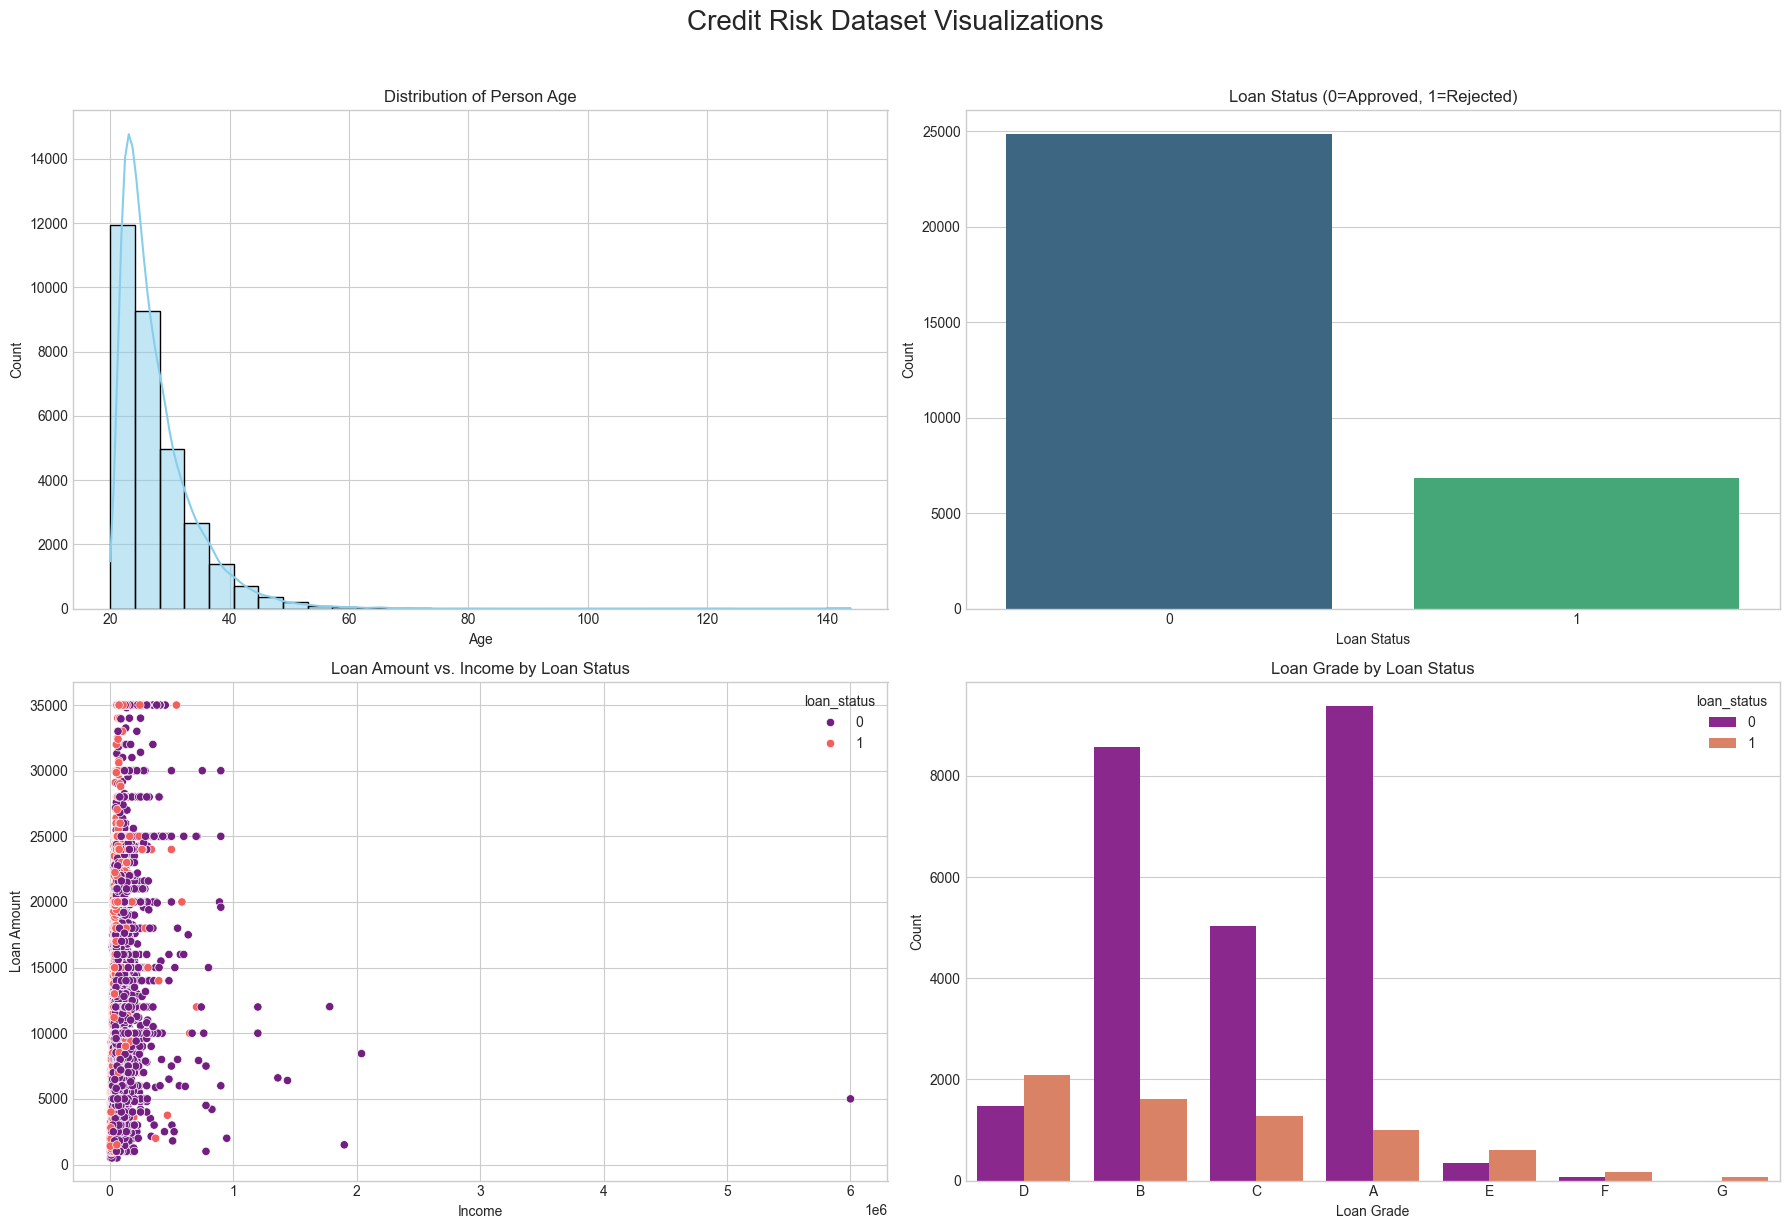

Visualizations displayed successfully.

Agent 3: Training and modeling...
Data split into training and testing sets.
Model training complete.
K-fold cross-validation results (5 folds): [0.92978304 0.93451677 0.93885602 0.93726573 0.93529296]
Mean accuracy from cross-validation: 0.94

Agent 4: Evaluating model performance...

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.92      0.99      0.96      4973
           1       0.97      0.70      0.81      1365

    accuracy                           0.93      6338
   macro avg       0.95      0.85      0.89      6338
weighted avg       0.93      0.93      0.93      6338



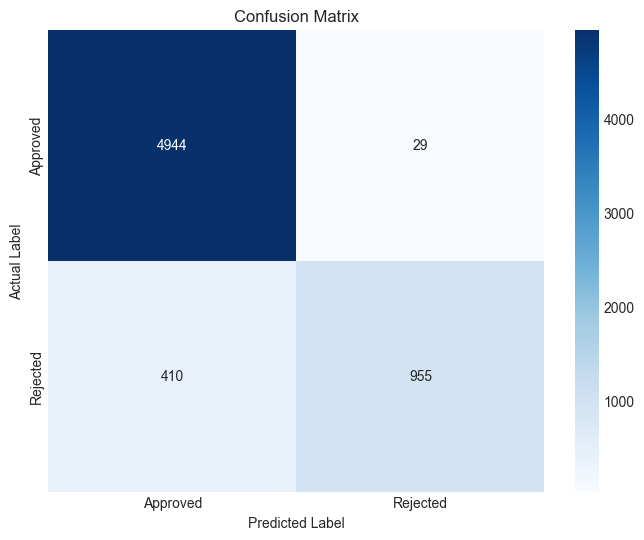

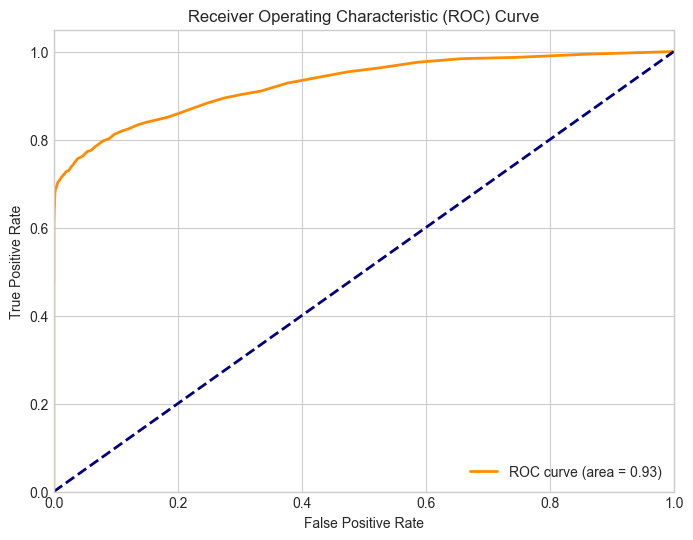


Agent 5: Making prediction on new data...
Prediction for the new applicant: Approved
Approval Probability: 0.97, Rejection Probability: 0.03

Agent 6: Explaining the model's prediction using SHAP...

Prediction: This applicant is **Approved**.
Probability of Approval: 0.97
Probability of Rejection: 0.03



SHAP Explanation (force plot and waterfall):
SHAP explanation failed: In v0.20, force plot now requires the base value as the first parameter! Try shap.plots.force(explainer.expected_value, shap_values) or for multi-output models try shap.plots.force(explainer.expected_value[0], shap_values[..., 0]).

Agent 9 (Pending): Chatbot implementation would go here.
This would involve an interactive loop where a user can ask questions about the data or make predictions.


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

try:
    import shap
except ImportError:
    print("SHAP library not found. Please install it with 'pip install shap'")
    shap = None


class DataAgent:
    def __init__(self, filename='credit_risk_dataset.csv'):
        self.filename = filename
        self.df = None

    def retrieve_and_preprocess(self):
        print("Agent 1: Retrieving and preprocessing data...")
        try:
            self.df = pd.read_csv(self.filename)
            print(f"Data successfully loaded from {self.filename}")
        except FileNotFoundError:
            print(f"Error: The file '{self.filename}' was not found.")
            return None, None, None, None, None

        # Fill missing loan interest rate with median
        self.df['loan_int_rate'].fillna(self.df['loan_int_rate'].median(), inplace=True)
        # Drop rows where person_emp_length is missing
        self.df.dropna(subset=['person_emp_length'], inplace=True)

        categorical_features = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
        numerical_features = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
                              'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']

        preprocessor = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), numerical_features),
                ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
            ])

        X = self.df.drop('loan_status', axis=1)
        y = self.df['loan_status']
        print("Data preprocessing complete.")
        return X, y, preprocessor, numerical_features, categorical_features


class VisualizationAgent:
    def __init__(self, df):
        self.df = df

    def visualize_data(self):
        if self.df is None:
            print("Visualization Agent: No data available to visualize.")
            return

        print("\nAgent 2: Generating data visualizations...")
        plt.style.use('seaborn-v0_8-whitegrid')
        fig, axes = plt.subplots(2, 2, figsize=(18, 12))
        fig.suptitle('Credit Risk Dataset Visualizations', fontsize=20, y=1.02)

        sns.histplot(self.df['person_age'], bins=30, kde=True, ax=axes[0, 0], color='skyblue')
        axes[0, 0].set_title('Distribution of Person Age')
        axes[0, 0].set_xlabel('Age')
        axes[0, 0].set_ylabel('Count')

        sns.countplot(x='loan_status', data=self.df, ax=axes[0, 1], palette='viridis')
        axes[0, 1].set_title('Loan Status (0=Approved, 1=Rejected)')
        axes[0, 1].set_xlabel('Loan Status')
        axes[0, 1].set_ylabel('Count')

        sns.scatterplot(x='person_income', y='loan_amnt', hue='loan_status', data=self.df, ax=axes[1, 0], palette='magma')
        axes[1, 0].set_title('Loan Amount vs. Income by Loan Status')
        axes[1, 0].set_xlabel('Income')
        axes[1, 0].set_ylabel('Loan Amount')

        sns.countplot(x='loan_grade', hue='loan_status', data=self.df, ax=axes[1, 1], palette='plasma')
        axes[1, 1].set_title('Loan Grade by Loan Status')
        axes[1, 1].set_xlabel('Loan Grade')
        axes[1, 1].set_ylabel('Count')

        plt.tight_layout()
        plt.show()
        print("Visualizations displayed successfully.")


class TrainingAgent:
    def __init__(self, preprocessor, model=RandomForestClassifier(n_estimators=100, random_state=42)):
        self.preprocessor = preprocessor
        self.model = model
        self.pipeline = None

    def train_model(self, X, y):
        print("\nAgent 3: Training and modeling...")

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y)
        print("Data split into training and testing sets.")

        self.pipeline = Pipeline(steps=[('preprocessor', self.preprocessor),
                                        ('classifier', self.model)])

        self.pipeline.fit(X_train, y_train)
        print("Model training complete.")

        kfold = KFold(n_splits=5, shuffle=True, random_state=42)
        cv_results = cross_val_score(self.pipeline, X_train, y_train, cv=kfold, scoring='accuracy')
        print(f"K-fold cross-validation results (5 folds): {cv_results}")
        print(f"Mean accuracy from cross-validation: {np.mean(cv_results):.2f}")

        # Return raw X_train for SHAP background data (do not preprocess here)
        return self.pipeline, X_train, X_test, y_test


class EvaluationAgent:
    def evaluate_model(self, model, X_test, y_test):
        print("\nAgent 4: Evaluating model performance...")
        y_pred = model.predict(X_test)

        print("\n--- Classification Report ---")
        print(classification_report(y_test, y_pred))

        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Approved', 'Rejected'], yticklabels=['Approved', 'Rejected'])
        plt.title('Confusion Matrix')
        plt.ylabel('Actual Label')
        plt.xlabel('Predicted Label')
        plt.show()

        y_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.show()


class PredictionAgent:
    def make_prediction(self, model, new_data):
        print("\nAgent 5: Making prediction on new data...")
        prediction = model.predict(new_data)[0]
        prediction_proba = model.predict_proba(new_data)[0]

        status = "Rejected" if prediction == 1 else "Approved"
        print(f"Prediction for the new applicant: {status}")
        print(f"Approval Probability: {prediction_proba[0]:.2f}, Rejection Probability: {prediction_proba[1]:.2f}")
        return prediction, new_data


class ExplanationAgent:
    def explain_prediction(self, pipeline, new_data_raw, X_train_raw):
        if shap is None:
            print("SHAP library is not installed. Please install it using 'pip install shap'.")
            return

        print("\nAgent 6: Explaining the model's prediction using SHAP...")

        try:
            model = pipeline.named_steps['classifier']
            preprocessor = pipeline.named_steps['preprocessor']
        except AttributeError:
            print("Error: Model pipeline is missing classifier or preprocessor.")
            return

        try:
            # Preprocess background data and new applicant here (must be raw data)
            background_data = preprocessor.transform(X_train_raw.sample(100, random_state=42))  # 100 samples for speed
            new_data_preprocessed = preprocessor.transform(new_data_raw)
        except Exception as e:
            print(f"Preprocessing error: {e}")
            return

        prediction = model.predict(new_data_preprocessed)[0]
        prediction_proba = model.predict_proba(new_data_preprocessed)[0]
        status = "Rejected" if prediction == 1 else "Approved"

        print(f"\nPrediction: This applicant is **{status}**.")
        print(f"Probability of Approval: {prediction_proba[0]:.2f}")
        print(f"Probability of Rejection: {prediction_proba[1]:.2f}")

        try:
            explainer = shap.TreeExplainer(model, data=background_data)
            shap_values = explainer.shap_values(new_data_preprocessed)

            shap.initjs()

            print("\nSHAP Explanation (force plot and waterfall):")

            # Check if shap_values is a list (for binary/multi-class) or a single array (for regression)
            if isinstance(shap_values, list):
                class_idx = 1  # For binary classification, we explain the rejection class (1)
                shap_values_for_plot = shap_values[class_idx][0]
                expected_value = explainer.expected_value[class_idx]
            else:
                shap_values_for_plot = shap_values[0]
                expected_value = explainer.expected_value

            feature_names = preprocessor.get_feature_names_out().tolist()

            # FORCE PLOT
            shap.plots.force(
                expected_value,
                shap_values_for_plot,
                feature_names=feature_names,
                matplotlib=True
            )
            plt.title(f"SHAP Force Plot - Why the loan was {status}")
            plt.show()

            # WATERFALL PLOT
            shap.plots.waterfall(
                shap.Explanation(values=shap_values_for_plot,
                                 base_values=expected_value,
                                 data=new_data_preprocessed[0],
                                 feature_names=feature_names),
                max_display=10
            )
            plt.title(f"SHAP Waterfall Plot - Why the loan was {status}")
            plt.show()

        except Exception as e:
            print(f"SHAP explanation failed: {e}")


class BusinessInsightAgent:
    def __init__(self, df):
        self.df = df

    def provide_insights(self):
        if self.df is None:
            print("\nBusiness Insights Agent: No data available.")
            return

        print("\nAgent 7: Providing business insights...")

        total_records = len(self.df)
        print(f"Total number of records in the dataset: {total_records}")

        loan_status_counts = self.df['loan_status'].value_counts()
        approved_count = loan_status_counts.get(0, 0)
        rejected_count = loan_status_counts.get(1, 0)

        approved_percent = (approved_count / total_records) * 100
        rejected_percent = (rejected_count / total_records) * 100

        print(f"Number of rejected loans: {rejected_count}")
        print(f"Number of approved loans: {approved_count}")
        print(f"Percentage of rejected loans: {rejected_percent:.2f}%")
        print(f"Percentage of approved loans: {approved_percent:.2f}%")

        print("\nCommon characteristics of rejected loans (loan_status=1):")
        rejected_df = self.df[self.df['loan_status'] == 1]
        print(rejected_df[['loan_grade', 'loan_intent', 'person_home_ownership']].mode().to_string(index=False))

        print("\nCommon characteristics of approved loans (loan_status=0):")
        approved_df = self.df[self.df['loan_status'] == 0]
        print(approved_df[['loan_grade', 'loan_intent', 'person_home_ownership']].mode().to_string(index=False))


def main():
    data_agent = DataAgent()
    X, y, preprocessor, numerical_features, categorical_features = data_agent.retrieve_and_preprocess()

    if X is not None:
        business_agent = BusinessInsightAgent(data_agent.df)
        business_agent.provide_insights()

        vis_agent = VisualizationAgent(data_agent.df)
        vis_agent.visualize_data()

        training_agent = TrainingAgent(preprocessor)
        pipeline, X_train, X_test, y_test = training_agent.train_model(X, y)

        eval_agent = EvaluationAgent()
        eval_agent.evaluate_model(pipeline, X_test, y_test)

        new_applicant = pd.DataFrame([{
            'person_age': 25,
            'person_income': 65000,
            'person_home_ownership': 'RENT',
            'person_emp_length': 5.0,
            'loan_intent': 'EDUCATION',
            'loan_grade': 'A',
            'loan_amnt': 15000,
            'loan_int_rate': 7.5,
            'loan_percent_income': 0.23,
            'cb_person_default_on_file': 'N',
            'cb_person_cred_hist_length': 5
        }])

        prediction_agent = PredictionAgent()
        prediction, new_data = prediction_agent.make_prediction(pipeline, new_applicant)

        explanation_agent = ExplanationAgent()
        explanation_agent.explain_prediction(pipeline, new_applicant, X_train)

        print("\nAgent 9 (Pending): Chatbot implementation would go here.")
        print("This would involve an interactive loop where a user can ask questions about the data or make predictions.")


if __name__ == "__main__":
    main()